# NEWS Headline Clustering-WOG

# Importing Packages

In [1]:
import re
import math
import pickle
import warnings
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from nltk.stem import PorterStemmer
from matplotlib import pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import silhouette_samples, silhouette_score
from scipy.cluster.hierarchy import dendrogram
import scipy.cluster.hierarchy as sch
warnings.filterwarnings("ignore", category=UserWarning)

You can read the data in your notebook in 3 ways:      
Step 1 and 2 are only for those who are running this notebook on Google Colab          
1) Upload data on your drive and mount your drive.(As I've done below)       
2) Upload the code by clicking Files option on the left side and click on upload files. Note: Files are removed once the session is finished so you have to upload it again.       
If you are running on localhost then you can simply read the data by placing the dataset files in the same notebook directory.

# Importing Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Run the below cell if you have uploaded the dataset and stopwords files in your drive, else you can upload the 

In [3]:
# Reading the csv file data into "Data" variable and reading stopwords from stopwords file. 

# Below 2 lines are reading dataset from drive
Data=pd.read_csv("/content/drive/MyDrive/Datasets/News Headline/abcnews-date-text.csv")
StopWords=open("/content/drive/MyDrive/Datasets/News Headline/Stopword-List.txt")

# If you want to read from within the directory or you have uploaded in the session then comment above 2 line and un-comment below 2 lines and run
# Data=pd.read_csv("abcnews-date-text.csv")
# StopWords=open("Stopword-List.txt")

StopWords=StopWords.readlines()
ps = PorterStemmer()

In [4]:
Data.head()

,publish_date,headline_text
0,20030219,aba decides against community broadcasting lic...
1,20030219,act fire witnesses must be aware of defamation
2,20030219,a g calls for infrastructure protection summit
3,20030219,air nz staff in aust strike for pay rise
4,20030219,air nz strike to affect australian travellers


In [5]:
Data.shape

(1103665, 2)

# Generating Graph (Graph of Words) and Word Sequences

In [6]:
class Graph(): 
#   Contructor: automatically called when Graph object is created
    def __init__(self):     
        self.dictionary = {}    
        self.Documents={}       
        self.StopWordList=self.GeneratingStopWordsList(StopWords)   
    
#   Function to remove '/n' from stopwords list
    def GeneratingStopWordsList(self,File):
        StopWordList=[]
        for word in StopWords:
            word=re.split("\\n",word)
            if word[0]!="":
                StopWordList.append(word[0].replace(" ",""))
        return StopWordList 

#   Parent function that iteratively calls MakeGraph()
    def MakeGraphs(self,Data):
        for i in range(0,len(Data['headline_text'])):       
            self.MakeGraph(Data['headline_text'][i])       
            self.Documents.setdefault(i,self.dictionary)        
            self.dictionary={}    
        return self.Documents   

    def MakeGraph(self,Document):    
        # Splitting into Tokens
        Tokens=re.split(" ",Document) 
        # Converting all tokens to lowercase
        Tokens=self.LOWERCASECONVERTOR(Tokens)   
        # Removing tokens which are stopwords   
        Tokens=self.RemovingStopWords(Tokens,self.StopWordList)    
        # Performing Stemming
        Tokens=self.PorterStemming(Tokens)

        for Index in range(0,len(Tokens)-1,2):   #Accessing 2 words that proceed the token. TOKENS ARE PICKED OUT AFTER EVERY 2 TOKEN. 
                                                 #for eg adding edge b/w 0->1,0->2.  2->3,2->4....     
            ThreeTokens=Tokens[Index:Index+3] 
            for i in range(1,3):         
                try:        
                    self.AddEdge(ThreeTokens[0],ThreeTokens[i])  
                except:             
                    self.AddEdge(ThreeTokens[0],"")              
                    pass 

#   Function to convert tokens into lowercase
    def LOWERCASECONVERTOR(self,Tokens):
        Result=[]
        for Token in Tokens:
            Result.append(Token.lower())
        return Result  

#   Function to remove stopwords
    def RemovingStopWords(self,Tokens,StopWordList):
        Result=[]
        for Token in Tokens:
            if Token not in StopWordList:
                Result.append(Token)
        return Result  

#   Function to perform Stemming
    def PorterStemming(self,Tokens):
        Result=[]
        for Token in Tokens:
            Result.append(ps.stem(Token))
        return Result

#   Function to show relationship b/w src and dest
    def AddEdge(self,Source,Destination):       
        if Source not in self.dictionary:           
            self.dictionary.setdefault(Source,[])           
            if Destination!="":               
                self.dictionary[Source].append(Destination)
        else:          
            if (Destination not in self.dictionary[Source]) and (Destination!=""):              
                self.dictionary[Source].append(Destination)

#   Generating a Sequence of each doc to print Graph
    def GenerateSequence(self):
        Sequence={}    
        for i in range(0,len(self.Documents)):         
            Sequence.setdefault(i,[])
            for j in data[i]:   
                for k in data[i][j]:       
                    l=[]      
                    l.append(j)
                    l.append(k)     
                    Sequence[i].append(l)      
        return Sequence

    def PrintGraph(self):    
        print(self.dictionary)  

    def GetDictionary(self):      
        return self.dictionary

# Constructing Graph of Documents

In [7]:
file1 = "/content/drive/MyDrive/Datasets/News Headline/GraphsOfDocuments.p"
try:
    File = open(file1,"rb")
    data=pickle.load(File)
except:
    print("File Not Found")
    Documents=Graph()
    data=Documents.MakeGraphs(Data)
    with open(file1, 'wb') as fp:
        pickle.dump(data,fp, protocol=pickle.HIGHEST_PROTOCOL)

In [8]:
print("Origninal Headlines\n")
Data['headline_text'].head(3)

Origninal Headlines



0    aba decides against community broadcasting lic...
1       act fire witnesses must be aware of defamation
2       a g calls for infrastructure protection summit
Name: headline_text, dtype: object

In [9]:
print("Graph of Headlines:\n")
{k: data[k] for k in list(data)[:3]}

Graph of Headlines:



{0: {'aba': ['decid', 'against'],
  'against': ['commun', 'broadcast'],
  'broadcast': ['licenc']},
 1: {'act': ['fire', 'wit'], 'wit': ['must', 'awar'], 'awar': ['defam']},
 2: {'g': ['call', 'infrastructur'], 'infrastructur': ['protect', 'summit']}}

# Generating Sequence

In [10]:
file2 = "/content/drive/MyDrive/Datasets/News Headline/SequenceOfDocuments.p"
try:
    File = open(file2,"rb")
    Sequence=pickle.load(File)
except:
    Sequence=Documents.GenerateSequence()
    with open(file2, 'wb') as fp:
        pickle.dump(Sequence,fp, protocol=pickle.HIGHEST_PROTOCOL)

In [11]:
print("Sequences of Headlines:\n")
{k: Sequence[k] for k in list(Sequence)[:3]}

Sequences of Headlines:



{0: [['aba', 'decid'],
  ['aba', 'against'],
  ['against', 'commun'],
  ['against', 'broadcast'],
  ['broadcast', 'licenc']],
 1: [['act', 'fire'],
  ['act', 'wit'],
  ['wit', 'must'],
  ['wit', 'awar'],
  ['awar', 'defam']],
 2: [['g', 'call'],
  ['g', 'infrastructur'],
  ['infrastructur', 'protect'],
  ['infrastructur', 'summit']]}

#                                                    Plotting Word Of Graph

In [12]:
def DisplayGraph(data,Sequence,Number):    
    G=nx.DiGraph()
    for key in data[Number].keys():
        G.add_node(key,label=key)
    for seq in Sequence[Number]:
        G.add_edge(seq[0],seq[1],color='blue')
    plt.figure(figsize=(10,5))
    plt.title("Graph Of Document : "+str(Number))
    nx.draw(G, pos = nx.nx_pydot.graphviz_layout(G),arrows=True, node_size=1900,node_color='yellow', linewidths=0.25, font_size=20,font_weight='bold', with_labels=True,font_color='black')
    plt.show()

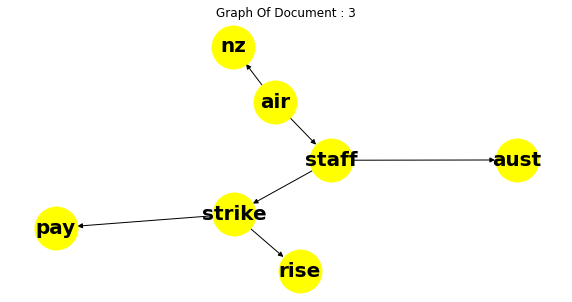

In [13]:
DisplayGraph(data,Sequence,3)

## Generating Similarity Matrix

In [14]:
def GenerateSimilarityMatrix(Number):   #Generating Sim matrix b/w docs to form clusters
    SimilarityMatrix=[[0 for i in range(0,Number)]for j in range(0,Number)]
    SimilarityDictionary={}
    for DocumentRow in range(0,Number):
        # print("Document No : ",DocumentRow)
        d1=Sequence[DocumentRow]
        SimilarityDictionary.setdefault(DocumentRow,{})
        for DocumentColumn in range(0,Number):
            Intersection=[]
            Union=[]
            d2=Sequence[DocumentColumn]
            for i in d1:    
                if i in d2:
                    Intersection.append(i)
                    Union.append(i)
                else:
                    Union.append(i)
            for j in d2:
                if j not in Union:
                    Union.append(j)     
            if len(Union)!=0 and (len(Intersection)/len(Union))>0:        
                SimilarityDictionary[DocumentRow].setdefault(DocumentColumn,(1-(len(Intersection)/len(Union))))    
            if len(Union)!=0:        
                SimilarityMatrix[DocumentRow][DocumentColumn]=(1-(len(Intersection)/len(Union)))
    return SimilarityMatrix

In [15]:
file3 = "/content/drive/MyDrive/Datasets/News Headline/SimilarityMatrix.p"
numOfDocs = 5000   # We are only generating a similarity matrix of first 5000 docs since there are alot of docs in the dataset
try:
    File = open(file3,"rb")
    SimilarityMatrix=pickle.load(File)
except:
    SimilarityMatrix=GenerateSimilarityMatrix(numOfDocs)
    with open(file3, 'wb') as fp:
        pickle.dump(SimilarityMatrix,fp, protocol=pickle.HIGHEST_PROTOCOL)

# Performing Hierarchical Agglomerative Clustering

In [19]:
try:
    File = open("/content/drive/MyDrive/Datasets/News Headline/linkage_matrix_complete.p","rb")
    linkage_matrix_complete=pickle.load(File)
    File = open("/content/drive/MyDrive/Datasets/News Headline/linkage_matrix_single.p","rb")
    linkage_matrix_single=pickle.load(File)
    File = open("/content/drive/MyDrive/Datasets/News Headline/linkage_matrix_average.p","rb")
    linkage_matrix_average=pickle.load(File)
    File = open("/content/drive/MyDrive/Datasets/News Headline/linkage_matrix_centroid.p","rb")
    linkage_matrix_centroid=pickle.load(File)
except:
    linkage_matrix_complete=sch.linkage(SimilarityMatrix[0:numOfDocs][0:numOfDocs], method='complete')
    with open('/content/drive/MyDrive/Datasets/News Headline/linkage_matrix_complete.p', 'wb') as fp:
        pickle.dump(linkage_matrix_complete,fp, protocol=pickle.HIGHEST_PROTOCOL)       
    linkage_matrix_average=sch.linkage(SimilarityMatrix[0:numOfDocs][0:numOfDocs], method='average')
    with open('/content/drive/MyDrive/Datasets/News Headline/linkage_matrix_average.p', 'wb') as fp:
        pickle.dump(linkage_matrix_average,fp, protocol=pickle.HIGHEST_PROTOCOL)
    linkage_matrix_single=sch.linkage(SimilarityMatrix[0:numOfDocs][0:numOfDocs], method='single')
    with open('/content/drive/MyDrive/Datasets/News Headline/linkage_matrix_single.p', 'wb') as fp:
        pickle.dump(linkage_matrix_single,fp, protocol=pickle.HIGHEST_PROTOCOL)
    linkage_matrix_centroid=sch.linkage(SimilarityMatrix[0:numOfDocs][0:numOfDocs], method='centroid')
    with open('/content/drive/MyDrive/Datasets/News Headline/linkage_matrix_centroid.p', 'wb') as fp:
        pickle.dump(linkage_matrix_centroid,fp, protocol=pickle.HIGHEST_PROTOCOL)

# Ploting Hierarchical Clustering Dendrogram

In [20]:
def plot_dendrogram(linkage_matrix, **kwargs):
    dendrogram(linkage_matrix, **kwargs)

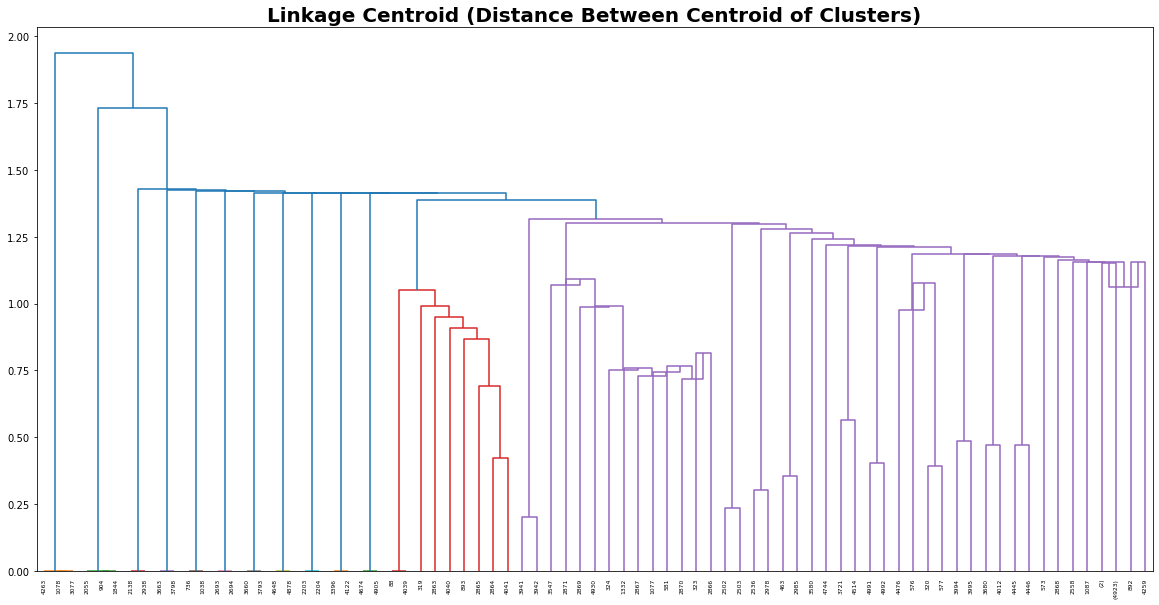

In [21]:
plt.figure(figsize=(20,10))
plt.title('Linkage Centroid (Distance Between Centroid of Clusters)',fontdict={'fontsize': 20, 'fontweight': 'bold'})
plot_dendrogram(linkage_matrix_centroid, truncate_mode='level')
plt.show()

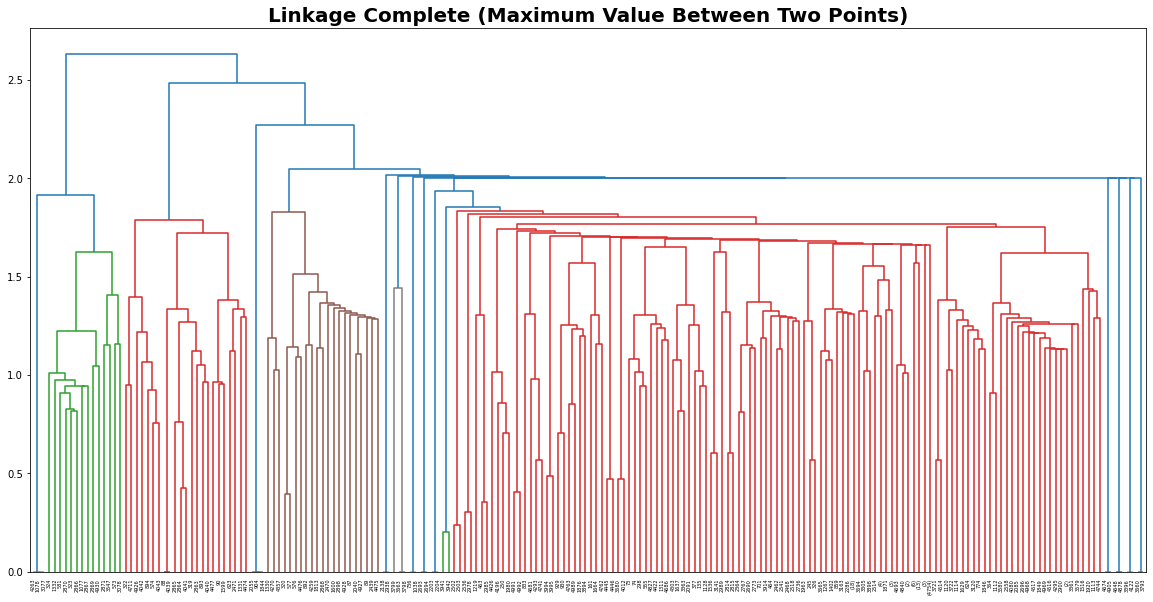

In [22]:
plt.figure(figsize=(20,10))
plt.title('Linkage Complete (Maximum Value Between Two Points)',fontdict={'fontsize': 20, 'fontweight': 'bold'})
plot_dendrogram(linkage_matrix_complete, truncate_mode='level')
plt.show()

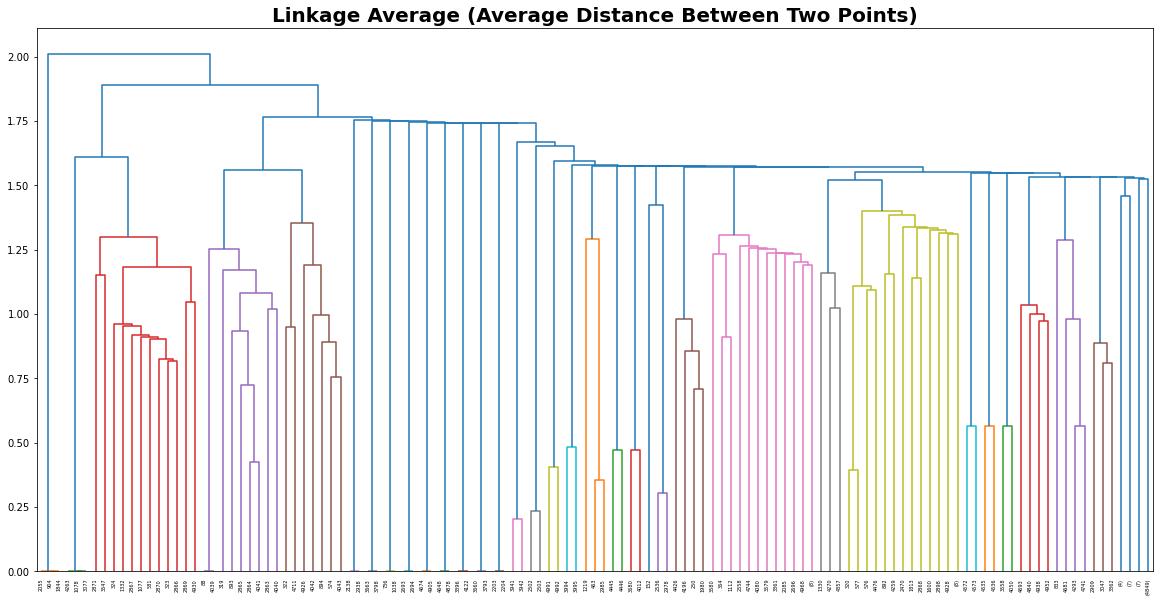

In [23]:
plt.figure(figsize=(20,10))
plt.title('Linkage Average (Average Distance Between Two Points)',fontdict={'fontsize': 20, 'fontweight': 'bold'})
plot_dendrogram(linkage_matrix_average, truncate_mode='level')
plt.show()

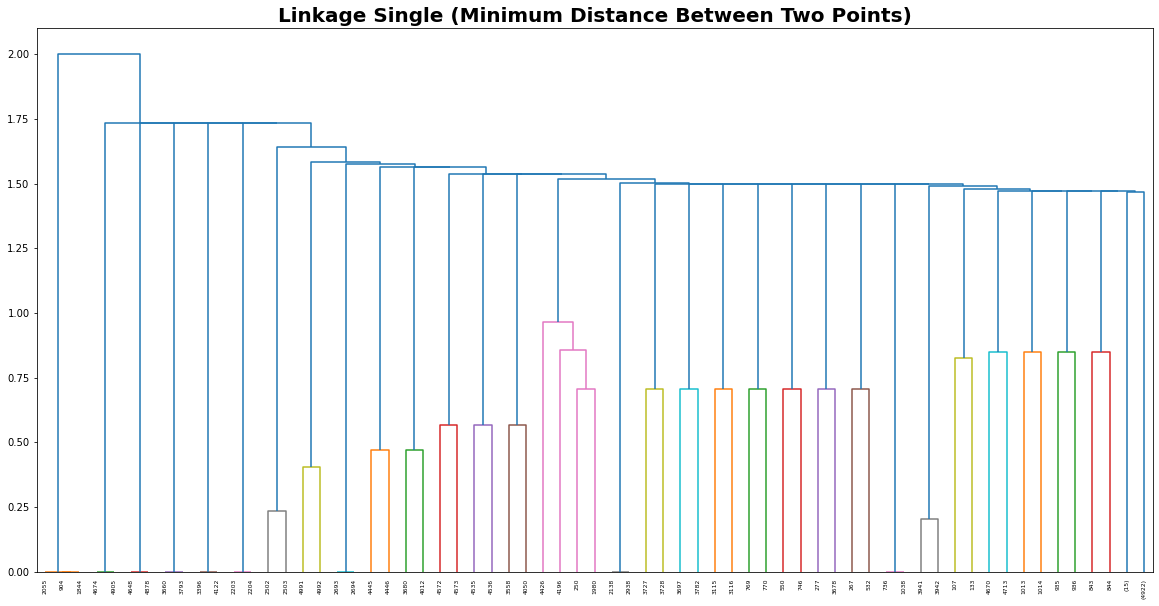

In [24]:
plt.figure(figsize=(20,10))
plt.title('Linkage Single (Minimum Distance Between Two Points)',fontdict={'fontsize': 20, 'fontweight': 'bold'})
plot_dendrogram(linkage_matrix_single, truncate_mode='level')
plt.show()

#Calculating Silhouette Scores for Clustering Evaluation of different linkage of HAC

### What is a Silhoutte coefficient?      
The silhouette coefficient is a measure of how similar a data point is within-cluster (cohesion) compared to other clusters (separation).        

### Points to remember while calculating silhouette coefficient:
- The value of the silhouette coefﬁcient is between [-1, 1].
- A score of 1 denotes the best meaning that the data point i is very compact within the cluster to which it belongs and far away from the other clusters.
- The worst value is -1. Values near 0 denote overlapping clusters.

In [39]:
Matrix=np.array(SimilarityMatrix)
Matrix=Matrix[:numOfDocs,:numOfDocs]
np.fill_diagonal(Matrix, 0)
silhoutte_scores=[]

Single_X=[]
Single_Y=[]
# print("Silhouette Scores for Single linkage")
for i in range(3,1000,40):
    nodes = sch.fcluster(linkage_matrix_single,t=i, criterion='maxclust')       # i here is max number of clusters
    silhouette_avg = silhouette_score(Matrix ,labels=nodes,metric='precomputed')
    # print("The average silhouette_score is :"+ str(silhouette_avg)+ "on "+str(i)+" number of clusters")
    Single_X.append(i)
    Single_Y.append(silhouette_avg)
silhoutte_scores.append((Single_X,Single_Y))

In [40]:
Average_X=[]
Average_Y=[]
# print("Silhouette Scores for Average linkage")
for i in range(3,1000,40):
    nodes = sch.fcluster(linkage_matrix_average,t=i, criterion='maxclust')
    silhouette_avg = silhouette_score(Matrix ,labels=nodes,metric='precomputed')
    # print("The average silhouette_score is :"+ str(silhouette_avg)+ "on "+str(i)+" number of clusters")
    Average_X.append(i)
    Average_Y.append(silhouette_avg)
silhoutte_scores.append((Average_X,Average_Y))

In [41]:
Complete_X=[]
Complete_Y=[]
Complete_points=[]
# print("Silhouette Scores for Complete linkage")
for i in range(3,1000,40):
    nodes = sch.fcluster(linkage_matrix_complete,t=i, criterion='maxclust')
    silhouette_avg = silhouette_score(Matrix ,labels=nodes,metric='precomputed')
    # print("The average silhouette_score is :"+ str(silhouette_avg)+ "on "+str(i)+" number of clusters")
    Complete_X.append(i)
    Complete_Y.append(silhouette_avg)
silhoutte_scores.append((Complete_X,Complete_Y))

In [42]:
Centroid_X=[]
Centroid_Y=[]
# print("Silhouette Scores for Centroid linkage")
for i in range(3,1000,40):
    nodes = sch.fcluster(linkage_matrix_centroid,t=i, criterion='maxclust')
    silhouette_avg = silhouette_score(Matrix ,labels=nodes,metric='precomputed')
    # print("The average silhouette_score is :"+ str(silhouette_avg)+ "on "+str(i)+" number of clusters")
    Centroid_X.append(i)
    Centroid_Y.append(silhouette_avg)
silhoutte_scores.append((Centroid_X,Centroid_Y))

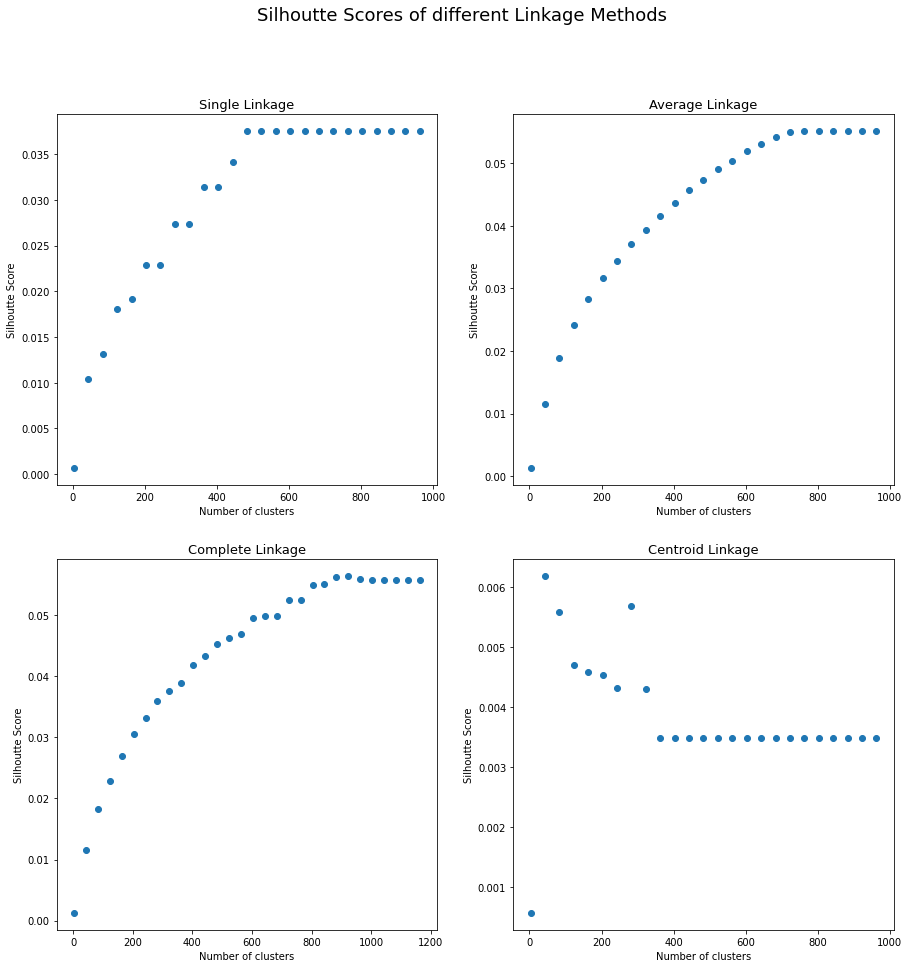

In [43]:
method_titles=["Single Linkage","Average Linkage","Complete Linkage","Centroid Linkage"]
fig,axs = plt.subplots(2,2,figsize=(15,15))
for method,ax,title in zip(silhoutte_scores,axs.ravel(),method_titles):
  ax.scatter(method[0],method[1])
  ax.set_xlabel("Number of clusters",fontsize=10)
  ax.set_ylabel("Silhoutte Score",fontsize=10)
  ax.set_title(title,fontsize=13)
plt.suptitle("Silhoutte Scores of different Linkage Methods",fontsize=18)
plt.show()

# Observation:      
### Single Linkage:     
- Max silhoutte score achieved:  0.037  (approx)      
- Min number of clusters:  550  (approx) 

### Average Linkage:     
- Max silhoutte score achieved:  0.055  (approx)      
- Min number of clusters:  750  (approx) 

### Complete Linkage:     
- Max silhoutte score achieved:  0.056  (approx)      
- Min number of clusters:  900  (approx) 

### Centroid Linkage:     
- Max silhoutte score achieved:  0.0035  (approx)      
- Min number of clusters:  400  (approx) 

Complete Linkage and Average Linkage both are performing better than the rest of the methods.

We can conclude that there are around 750 or 900 clusters in the first 5000 headlines of the dataset